In [1]:
######################################### Import statements ###########################################

import sys
sys.path.append("..")   # this allows us to import from sibling directory

from code_to_import.dataset_preprocessing import ProductionModeDataset

import argparse
import os
import numpy as np
import math
import sys
#import torchvision.transforms as transforms
#from torchvision.utils import save_image

from torch.utils.data import DataLoader
#from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F   # NOTE: I don't think this is used
import torch.autograd as autograd
import torch

from matplotlib import pyplot as plt
from IPython import display


print(torch.cuda.is_available())

False


In [4]:
######################## THIS CLASS INCLUDES ALL THE VARIABLES YOU WANT TO CONFIGURE #################################
#######################################################################################################################

class opt():   # Class used for optimizers in the future. Defines all variables and stuff needed.
#     save_weights = True  # Tells whether to save weights... currently not used
    
    load_model = False  # set true if you want to load and continue training a previous model
    
    draw = True # set to false when running on slurm
    
    n_epochs = 40000   # an epoch is the number of times it works through the entire training set.
                       # This sets the total number of epochs which will be run
    
    batch_size = 5000   # the training set is broken up into batches, 
                        # this sets the size of each batch
    
    weight_cmd = "true"   # could also be "true", "false" and "no-neg".
                          # This determines whether weights and negative weights are used
        
    drop = 0.2   # percentage of nodes which will be dropped each time
    
    lr = 0.0001   # learning rate (how much to change based on error)
    b1 = 0.9   # Used for Adam. Exponential decay rate for the first moment
    b2 = 0.999   # Used for Adam. Exponential decay rate for the second moment estimates (gradient squared)
        
    correlation_cut = -1  # this is the correlation cut... If negative then no cut is applied
    
    # the root_path leads to the folder with the root files being used for data
    root_path = "/depot/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files/Nominal"

    file = root_path + "/" + "ee" + "_modified_root_1_spinCorr.root"   # this is the data root file loaded into the dataloader
    
    # this is the model name. Change it when running a new model
    model_name = "testthreeLayerModel_ee_corrCut_" + str(correlation_cut)  + "_weights_" + weight_cmd + "_drop_" + str(drop)
    
    # load data object so we can access validation and training data
    if correlation_cut > 0:
        data = ProductionModeDataset(file, correlation_cut=correlation_cut)
    else:
        data = ProductionModeDataset(file)

print("The model in this run is " + opt.model_name)   # this will make slurm output easier to identify


cuda = True if torch.cuda.is_available() else False


############################## Configure data loader depending on if there is a correlation cut ###########################
if opt.correlation_cut > 0:
    os.makedirs("../data/three_layers/", exist_ok=True)
    dataloader = torch.utils.data.DataLoader(
        opt.data,
        batch_size=opt.batch_size, drop_last=True,
        shuffle=True,
    )
else:
    os.makedirs("../data/three_layers/", exist_ok=True)
    dataloader = torch.utils.data.DataLoader(
        opt.data,
        batch_size=opt.batch_size, drop_last=True,
        shuffle=True
    )
print('done')

data = iter(dataloader)
x = data.next()
input_size = x.shape[1] -3



['l_eta', 'lbar_eta', 'l_phi', 'lbar_phi', 'l_pt', 'lbar_pt', 'l_mass', 'lbar_mass', 'b_eta', 'bbar_eta', 'b_phi', 'bbar_phi', 'b_pt', 'bbar_pt', 'b_mass', 'bbar_mass', 'production_mode', 'eventWeight', '__index__']
num qqbar = 52908
training (128566, 19)
evaluating (30158, 19)
The model in this run is testthreeLayerModel_ee_corrCut_-1_weights_true_drop_0.2
done


In [5]:
###################### Now save training and validation sets for future analysis ###################################
np.save("../data/three_layers/train_val_datasets/training_dataset_" + opt.model_name + ".npy", opt.data.get_training_data())
np.save("../data/three_layers/train_val_datasets/validation_dataset_" + opt.model_name + ".npy", opt.data.get_eval_data())


In [6]:
class Classifier(nn.Module):
    """
    classifier layers
    """
    def __init__(self):
        super(Classifier, self).__init__()   # Just uses the module constructor with name Discriminator 

        self.model = nn.Sequential(
            nn.Linear(input_size, 512),   # first layer
            nn.BatchNorm1d(512),   # batch normalization
            nn.Dropout(opt.drop),   # add dropout
            nn.LeakyReLU(0.2, inplace=True),   # apply leaky relu to layer
            nn.Linear(512, 256),
            nn.Dropout(opt.drop),   # add dropout
            nn.BatchNorm1d(256),# batch normalization
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 3),
            
            # these are commented out because the last layer should have this happen
#             nn.Dropout(drop),   # add dropout
#             nn.BatchNorm1d(3),  # batch normalization
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, input):
        """
        applies model to input and attempts to classify
        """
        output = self.model(input)   # Classifies the input (at location) as gg (0) qqbar (1) or other (2)
        return output


# ******* OUT OF CLASSES NOW ************

############### Initialize classifier and load a model if needed ##########################
classifier = Classifier()
if opt.load_model:
    classifier.load_state_dict(torch.load("../models/three_layers/" + opt.model_name + ".pt")) #load module with same name
    classifier.train()  # set the model up for training
if cuda:
    classifier.cuda()

    



In [7]:
####################################### load data for evaluation of model (not training set) and separate weights and target
validation_data = opt.data.get_eval_data()

w_val = validation_data[:,input_size + 1]

target_val = validation_data[:,input_size]
target_val = Variable(torch.from_numpy(target_val).type(torch.LongTensor))
y_val = np.transpose(validation_data)
y_val = np.delete(y_val, [input_size, input_size + 1, input_size + 2], 0)
y_val = np.transpose(y_val)
val_data = Variable(torch.from_numpy(y_val).type(torch.Tensor))

 # replace all negative weighted events with zero if the weight_cmd says to
if opt.weight_cmd == "no-neg":
    w_val[w_val < 0] = 0

# remove weighting (aka, set all to 1) if weight_cmd says to
if opt.weight_cmd == "false":
    w_val = np.ones(w_val.shape)
    
w_val = Variable(torch.from_numpy(w_val).type(torch.FloatTensor))

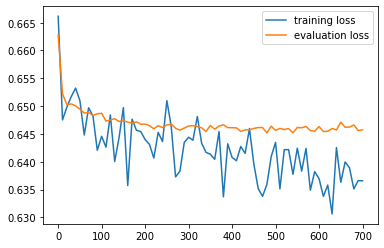

0.6402512
0.6378764
0.6384594
0.63011515


In [ ]:
################### Initialize (and load if needed) optimizer and loss function ################################
################################################################################################################
optimizer = torch.optim.Adam(classifier.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2)) # set up optimizer
if opt.load_model:
    optimizer.load_state_dict(torch.load("../models/three_layers/optimizer_" + opt.model_name + ".pt"))

criterion = nn.CrossEntropyLoss(reduce=False)# this is the loss function. reduce=false makes it return a value for each input

##################################################################################################
################ initialize stuff before training ################################################

small_loss = 1e20   # This is the initail loss under which we overwrite the model.
                    # initialize with a large loss so everything is smaller than it

# initialize loss arrays
loss_val_array = np.array(())
loss_array = np.array(())
lva = 0  # this is the length of the loaded array
la = 0  # this is the length of the other loaded array

# load arrays and reset small_loss if loading model:
if opt.load_model:
    loss_val_array = np.load("../data/three_layers/" + opt.model_name +  "_loss_val_array.npy")
    lva = len(loss_val_array)

    loss_array = np.load("../data/three_layers/" + opt.model_name +  "_loss_train_array.npy")
    la = len(loss_array)
    
    small_loss = np.min(loss_val_array)
    

batches_done = 0   # Counter for batches


###############################################################################################################
# ******************************** START TRAINING LOOP *******************************************************
###############################################################################################################
for epoch in range(opt.n_epochs):   # Loop through all epochs
    for i, x in enumerate(dataloader): # x is a batch and there are i batches in the epoch
        
        #-----------------------------
        # Configure input
        #----------------------------
        variable_len = len(x[0])
        weight = x[:, variable_len-2]
        weight = Variable(weight.type(torch.FloatTensor))
        target = x[:, variable_len-3]
        target = Variable(target.type(torch.LongTensor))
        x = np.transpose(x)
        x = np.delete(x, [variable_len-3, variable_len-2, variable_len-1], 0)
        x = np.transpose(x)
        batch = Variable(x.type(torch.Tensor))   # Variable is a wrapper for the Tensor x was just made into
        
        # replace all negative weighted events with zero if the weight_cmd says to
        if opt.weight_cmd == "no-neg":
            weight[weight < 0] = 0
            #weight = Variable(torch.from_numpy(weight).type(torch.FloatTensor))
        
        # remove weighting (aka, set all to 1) if weight_cmd says to
        if opt.weight_cmd == "false":
            weight = np.ones(weight.shape)
            weight = Variable(torch.from_numpy(weight).type(torch.FloatTensor))

        # ---------------------
        #  Train Classifier
        # ---------------------

        optimizer.zero_grad()   # Make gradients zero so they don't accumulate
        
        output = classifier(batch)   # apply nn to input   

        # Calculate loss 
        loss_l = criterion(output, target) # loss_l is a vector with the loss for each event in the batch
        loss = torch.dot(weight,loss_l)/(loss_l.shape[0])   # we take the dot product with the weights to calculate the final loss
        loss.backward()   # Do back propagation 
        optimizer.step()   # Update parameters based on gradients for individuals
        batches_done += 1  # increase the number of batches in the counter
        
    
    #-----------------------------------------
    # Save and Draw Stuff  (if drawing is on)
    #-----------------------------------------
    if epoch % 10 == 0:
        print(loss.detach().numpy())
        loss_array = np.append(loss_array, loss.detach().numpy()) # append the training loss to the loss array
        
        
        out = classifier(val_data)   # run classifier on validation data to see how good it is
        loss_val = torch.dot(w_val, criterion(out, target_val))/(target_val.shape[0])   # calculate the validation loss
        loss_val_array = np.append(loss_val_array, loss_val.detach().numpy()) # append the validation loss to its array
        
        if small_loss > loss_val:   # compare to see if the loss has decreased
            small_loss = loss_val   # if the network has improved replace the best loss with this one
            torch.save(classifier.state_dict(), "../models/three_layers/" + opt.model_name + ".pt")   # save the new (and better) model
            torch.save(optimizer.state_dict(), "../models/three_layers/optimizer_" + opt.model_name + ".pt") # save the optimizer state
            
        if epoch % 50 == 0:
            # save the loss arrays
            np.save("../data/three_layers/" + opt.model_name +  "_loss_val_array.npy",loss_val_array)
            np.save("../data/three_layers/" + opt.model_name + "_loss_train_array.npy",loss_array)
            if opt.draw:
                #----------------------------------
                # Draw training and validation loss
                #-------------------------------------
                display.clear_output(True)
                figure = plt.figure()
                ax = figure.add_subplot(111)
                #ax.set_yscale("log")
                ax.plot(10 * np.array(list(range(int((epoch)/10)+lva+1))), loss_array, label="training loss")
                ax.plot(10 * np.array(list(range(int((epoch)/10)+la+1))), loss_val_array, label = "evaluation loss")
                plt.legend()
                plt.show()


